# Kernel Adaptive Subspace Detector (KASD) for Hyperspectral Imagery

#### Make sure both HDR files (subset_data100517.hdr &subset_data100517) are in ./data/ directory

<a href="#section1">1. HSI Data Loading & Pre-processing</a><br>
<a href="#section1.1" style="margin-left:20px">1.1. Load/Preprocess Data </a><br>
<a href="#section1.2" style="margin-left:20px">1.2. ROI Visualization - RGB Channels (436 X 449) </a><br>
<a href="#section1.3" style="margin-left:20px">1.3. ROI Ground Truth - RGB Channels (436 X 449) </a><br>
<a href="#section1.4" style="margin-left:20px">1.4. Background/Target Data With & Without MNF </a><br>

<a href="#section2">2. ASD </a><br>
<a href="#section2.1" style="margin-left:20px">2.1. Helper Functions </a><br>
<a href="#section2.2" style="margin-left:20px">2.2. ASD without MNF </a><br>
<a href="#section2.3" style="margin-left:20px">2.3. ASD with MNF </a><br>

<a href="#section3">3. Kernel ASD (KASD) </a><br>
<a href="#section3.1" style="margin-left:20px">3.1. Common Helper Functions </a><br>

<a href="#section4">4. KASD (Gaussian Kernel)</a><br>
<a href="#section4.1" style="margin-left:20px">4.1. KASD (Gaussian) Without MNF </a><br>
<a href="#section4.2" style="margin-left:20px">4.2. KASD (Gaussian) with MNF </a><br>

<a href="#section5">5. KASD (Polynomial Kernel)</a><br>
<a href="#section5.1" style="margin-left:20px">5.1. KASD (Polynomial) Without MNF </a><br>
<a href="#section5.2" style="margin-left:20px">5.2. KASD (Polynomial) with MNF </a><br>

<a href="#section6">6. KASD (Spectral Angle Kernel)</a><br>
<a href="#section6.1" style="margin-left:20px">6.1. KASD (Spectral Angle) Without MNF </a><br>
<a href="#section6.2" style="margin-left:20px">6.2. KASD (Spectral Angle) with MNF </a><br>

<a href="#section7">7. Combined Plot</a><br>

<a href="#section8">8. ROC</a><br>

In [2]:
import pickle as pkl
import numpy as np
import random
import sympy

import spectral.io.envi as envi
from spectral import *

import pysptools.noise as ns

from sklearn import cluster, datasets, mixture
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.datasets import make_spd_matrix
from scipy.stats import multivariate_normal

from PIL import Image
from sklearn.metrics import roc_curve

from joblib import Parallel, delayed
from joblib import parallel_backend

from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

import warnings
warnings.filterwarnings("ignore")

<a id="section1"></a>
# 1.  HSI Data Loading & Pre-processing

<a id="section1.1"></a>
## 1.1. Load & Preprocess Data

### MNF transform is done on line 6 & 7 below to getthe MNF version of  ROI (ROI_MNF)

In [8]:
ROI = envi.open('./data/subset_data100517.hdr', './data/subset_data100517')

# ROI_MNF = envi.open('./data/Subset_data_MNF.hdr', './data/Subset_data_MNF')

# getting MNF version
mnf = ns.MNF()
ROI_MNF = mnf.apply(ROI[:,:,:])

print("ROI Shape:", ROI.shape)
print("ROI MNF Shape:", ROI_MNF.shape)

# wavelength: Red ~ 669, Green ~ 549, Blue ~ 474 
rgb_bands = (32, 20, 12)

target_pixels = [[222, 22], [222,23], [222,24], [222,25], [223,26],
                 [265,8], [265,17], [264,18], 
                 [265,32], [268, 32], [270,32], [268,29], [266,14], # x
                 [118,326], [121, 322], [125, 352], # x
                 [121,328], [122,340], 
                 [249, 366], [252,375], 
                 [322, 272], [342,293],
                 [384,102], [421,60], [422,63],
                 [326,258],
                 [338, 274],
                 [353, 290],
                 [317, 247]]

## Without MNF
target_spectrums = np.zeros((len(target_pixels), ROI.shape[2]))
for i in range(len(target_pixels)):
    target_spectrums[i,:] = ROI[target_pixels[i][0], target_pixels[i][1], :]
print(target_spectrums.shape)
avg_target_spectrum = np.sum(target_spectrums, axis=0)/len(target_pixels)
avg_target_spectrum = avg_target_spectrum.reshape(1,-1)
print(avg_target_spectrum.shape)
# target_spectrums = np.concatenate([target_spectrums, avg_target_spectrum], axis=0)
print(target_spectrums.shape)
print("---------")

## With MNF
target_spectrums_MNF = np.zeros((len(target_pixels), ROI_MNF.shape[2]))
for i in range(len(target_pixels)):
    target_spectrums_MNF[i,:] = ROI_MNF[target_pixels[i][0], target_pixels[i][1], :]
print(target_spectrums_MNF.shape)
avg_target_spectrum_MNF = np.sum(target_spectrums_MNF, axis=0)/len(target_pixels)
avg_target_spectrum_MNF = avg_target_spectrum_MNF.reshape(1,-1)
print(avg_target_spectrum_MNF.shape)
# target_spectrums_MNF = np.concatenate([target_spectrums_MNF, avg_target_spectrum_MNF], axis=0)
print(target_spectrums_MNF.shape)

ROI Shape: (436, 449, 187)
ROI MNF Shape: (436, 449, 187)
(29, 187)
(1, 187)
(29, 187)
---------
(29, 187)
(1, 187)
(29, 187)


<a id="section1.2"></a>
## 1.2. ROI Visualization - RGB Channels (436 x 449)
#### Orange pixels are oil spills

ROI_RGB Shape: (436, 449, 3)


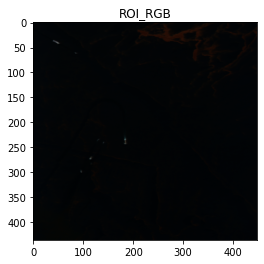

In [10]:
ROI_RGB = ROI[:,:,rgb_bands]
print("ROI_RGB Shape:", ROI_RGB.shape)
  
plt.imshow(ROI_RGB)
plt.title("ROI_RGB")
plt.savefig("./pics/ROI_RGB.png")

<a id="section1.3"></a>
## 1.3.  ROI Ground Truth Visualization - RGB Channels (436 x 449)

### Creating the o/1 label for Orange fixels for oil spill & background pixels

GT_RGB  Shape: (436, 449, 3)


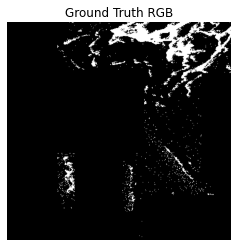

In [11]:
GT_RGB = np.zeros((ROI.shape[0], ROI.shape[1], 3))

for i in range(GT_RGB.shape[0]):
    for j in range(GT_RGB.shape[1]):
        
        # Using all spectral bands
        pixel_spectrum = ROI[i,j,:].reshape(1, -1)
        pixel_dist = [np.sqrt(np.sum(target_spectrums[i,:] - pixel_spectrum)**2)
                for i in range(target_spectrums.shape[0])]
        
        min_dist_target_spectrum = min(pixel_dist)
        
#         print(min_dist_target_spectrum)

        if min_dist_target_spectrum >= 3e-1:
            GT_RGB[i,j,:] = 1    
            
print("GT_RGB  Shape:", GT_RGB.shape)  


for i in range(0,436):
    for j in range(0,101):
        GT_RGB[i,j,:] = 0
        
for i in range(96,262):
    for j in range(0,275):
        GT_RGB[i,j,:] = 0        

for i in range(346,436):
    for j in range(272,449):
        GT_RGB[i,j,:] = 0  

for i in range(256,436):
    for j in range(136,231):
        GT_RGB[i,j,:] = 0 
        
for i in range(380,436):
    for j in range(100,264):
        GT_RGB[i,j,:] = 0 

for i in range(102,321):
    for j in range(390,449):
        GT_RGB[i,j,:] = 0 
        
plt.axis('off')
plt.imshow(GT_RGB)
plt.title("Ground Truth RGB")
plt.savefig("./pics/GT_RGB.png", bbox_inches='tight', transparent=True, pad_inches=0)

<a id="section1.4"></a>
## 1.4.  Background/Target Data - With & Without MNF

### Using k-means clustering to select 300 representative pixels for background & target each

In [7]:
# Using k-means clustering to reduce data sample size
background, target = [], []
background_MNF, target_MNF = [], []

for i in range(GT_RGB.shape[0]):
    for j in range(GT_RGB.shape[1]):
        
        if sum(GT_RGB[i,j,:]) == 0.0:
            background.append(ROI[i, j, :].reshape(-1,1))
            background_MNF.append(ROI_MNF[i, j, :].reshape(-1,1))
        else:
            target.append(ROI[i, j, :].reshape(-1,1))
            target_MNF.append(ROI_MNF[i, j, :].reshape(-1,1))             

            
#### Without MNF ################
print("Starting Without MNF")
background = np.array(background)
background = background.reshape(background.shape[0], background.shape[1])
print("background Pixels Shape:", background.shape)

kmeans_background = KMeans(n_clusters=300, random_state=0).fit(background)
centroids_background = kmeans_background.cluster_centers_
print("Background Centroids Shape:", centroids_background.shape)

target = np.array(target)
target = target.reshape(target.shape[0], target.shape[1])
print("Target Pixels Shape:", target.shape)

kmeans_target = KMeans(n_clusters=300, random_state=0).fit(target)
centroids_target = kmeans_target.cluster_centers_
print("Target Centroids Shape:", centroids_target.shape)

# independent targets needed for K(X,Y) & K(Y,Y) calculation later
_, inds = sympy.Matrix(centroids_target).T.rref()
independent_targets = centroids_target[np.array(inds)]
print("Independent Target Shape", independent_targets.shape)
#######################################

print("-------------")


#### Without MNF ################
print("Starting With MNF")
background_MNF = np.array(background_MNF)
background_MNF = background_MNF.reshape(background_MNF.shape[0], background_MNF.shape[1])
print("background_MNF Pixels Shape:", background_MNF.shape)

kmeans_background_MNF = KMeans(n_clusters=300, random_state=0).fit(background_MNF)
centroids_background_MNF = kmeans_background_MNF.cluster_centers_
print("Background_MNF Centroids Shape:", centroids_background_MNF.shape)

target_MNF = np.array(target_MNF)
target_MNF = target_MNF.reshape(target_MNF.shape[0], target_MNF.shape[1])
print("Target_MNF Pixels Shape:", target_MNF.shape)

kmeans_target_MNF = KMeans(n_clusters=300, random_state=0).fit(target_MNF)
centroids_target_MNF = kmeans_target_MNF.cluster_centers_
print("Target_MNF Centroids Shape:", centroids_target_MNF.shape)

# independent targets needed for K(X,Y) & K(Y,Y) calculation later
_, inds = sympy.Matrix(centroids_target_MNF).T.rref()
independent_targets_MNF = centroids_target_MNF[np.array(inds)]
print("Independent Target MNF Shape", independent_targets_MNF.shape)
#######################################


# Save to reload directly later if needed (without MNF)
with open("./kernel_data/centroids_background.pkl","wb") as f:
    pkl.dump(centroids_background, f)
    
with open("./kernel_data/centroids_target.pkl","wb") as f:
    pkl.dump(centroids_target, f)
    
with open("./kernel_data/background.pkl","wb") as f:
    pkl.dump(background, f)
    
with open("./kernel_data/target.pkl","wb") as f:
    pkl.dump(target, f)
    
with open("./kernel_data/independent_targets.pkl","wb") as f:
    pkl.dump(independent_targets, f)
    
    
# Save to reload directly later if needed (with MNF)
with open("./kernel_data/centroids_background_MNF.pkl","wb") as f:
    pkl.dump(centroids_background_MNF, f)
    
with open("./kernel_data/centroids_target_MNF.pkl","wb") as f:
    pkl.dump(centroids_target_MNF, f)
    
with open("./kernel_data/background_MNF.pkl","wb") as f:
    pkl.dump(background_MNF, f)
    
with open("./kernel_data/target_MNF.pkl","wb") as f:
    pkl.dump(target_MNF, f)
    
with open("./kernel_data/independent_targets_MNF.pkl","wb") as f:
    pkl.dump(independent_targets_MNF, f)    

background Pixels Shape: (184805, 187)
Background Centroids Shape: (300, 187)
Target Pixels Shape: (10959, 187)
Target Centroids Shape: (300, 187)
Independent Target Shape (187, 187)
-------------
Starting With MNF
background_MNF Pixels Shape: (184805, 187)
Background_MNF Centroids Shape: (300, 187)
Target_MNF Pixels Shape: (10959, 187)
Target_MNF Centroids Shape: (300, 187)
Independent Target MNF Shape (187, 187)


In [12]:
## Reload saved data if necessary to avoid step 1.4 above
# without MNF
with open("./kernel_data/centroids_background.pkl","rb") as f:
    centroids_background = pkl.load(f)
    
with open("./kernel_data/centroids_target.pkl","rb") as f:
    centroids_target = pkl.load(f)
    
with open("./kernel_data/background.pkl","rb") as f:
    background = pkl.load(f)
    
with open("./kernel_data/target.pkl","rb") as f:
    target = pkl.load(f)
    
with open("./kernel_data/independent_targets.pkl","rb") as f:
    independent_targets = pkl.load(f)

    
# with MNF
with open("./kernel_data/centroids_background_MNF.pkl","rb") as f:
    centroids_background_MNF = pkl.load(f)
    
with open("./kernel_data/centroids_target_MNF.pkl","rb") as f:
    centroids_target_MNF = pkl.load(f)
    
with open("./kernel_data/background_MNF.pkl","rb") as f:
    background_MNF = pkl.load(f)
    
with open("./kernel_data/target_MNF.pkl","rb") as f:
    target_MNF = pkl.load(f)
    
with open("./kernel_data/independent_targets_MNF.pkl","rb") as f:
    independent_targets_MNF = pkl.load(f)
    
print("Without MNF")    
print("background Pixels Shape:", background.shape)
print("Background Centroids Shape:", centroids_background.shape)
print("Target Centroids Shape:", centroids_target.shape)
print("Independent Target Shape", independent_targets.shape)
print("-----")

print("With MNF")
print("background_MNF Pixels Shape:", background_MNF.shape)
print("Background_MNF Centroids Shape:", centroids_background_MNF.shape)
print("Target_MNF Centroids Shape:", centroids_target_MNF.shape)
print("Independent Target MNF Shape", independent_targets_MNF.shape)

Without MNF
background Pixels Shape: (184805, 187)
Background Centroids Shape: (300, 187)
Target Centroids Shape: (300, 187)
Independent Target Shape (187, 187)
-----
With MNF
background_MNF Pixels Shape: (184805, 187)
Background_MNF Centroids Shape: (300, 187)
Target_MNF Centroids Shape: (300, 187)
Independent Target MNF Shape (187, 187)


<a id="section2"></a>
## 2. ASD

<a id="section2.1"></a>
## 2.1.  Helper Functions

In [30]:
def ASD(x, C_Inv, U, mat):
    # eqn 2 of paper
    numerator = np.matmul(x.T, C_Inv)
    numerator = np.matmul(numerator,U)
    numerator = np.matmul(numerator, mat)
    numerator = np.matmul(numerator, U.T)
    numerator = np.matmul(numerator, C_Inv)
    numerator = np.matmul(numerator, x)
    
    denominator = np.matmul(x.T, C_Inv)
    denominator = np.matmul(denominator, x)
    denominator += 1e-5 # to avoid zero division

    ratio = numerator/denominator # equation 2 of paper 
    
    return ratio



def get_ASD_metrics(GT_RGB, roi, C_Inv, U, mat, ETA_THRESHOLD, show_val=False, threshold_cond="gt"):
    predictions_ASD = np.zeros((roi.shape[0],roi.shape[1],3))
    y_ASD = []

    PREDS_ASD, GT_LABELS_ASD = [], []

    for i in range(roi.shape[0]):
        for j in range(roi.shape[1]):
            current_pixel_spectrum = roi[i,j,:]
            current_pixel_spectrum = current_pixel_spectrum.reshape(-1,1)

            y = ASD(current_pixel_spectrum, C_Inv, U, mat)
            
            if show_val:
                print(y)
                
            if threshold_cond=="gt": 
                if y >= ETA_THRESHOLD:
                    predictions_ASD[i,j,:] = 1
                else:
                    predictions_ASD[i,j,:] = 0    
            else:
                if y <= ETA_THRESHOLD:
                    predictions_ASD[i,j,:] = 1
                else:
                    predictions_ASD[i,j,:] = 0                  

            # save y value for thresholding for ROC curve later
            y_ASD.append(y)

            # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
            gt = sum(GT_RGB[i,j,:])
            if gt == 0.0:
                GT_LABELS_ASD.append(0)
            else:
                GT_LABELS_ASD.append(1)

            pred = sum(predictions_ASD[i,j,:])            
            if pred == 0.0:
                PREDS_ASD.append(0)
            else:
                PREDS_ASD.append(1)
                
    return predictions_ASD, y_ASD, PREDS_ASD, GT_LABELS_ASD


<a id="section2.2"></a>
## 2.2.  ASD Without MNF

background_pixels Pixels Shape: (187, 194798)
target_pixels Pixels Shape: (187, 966)
U Shape: (187, 187)
Covariance Matrix Shape: (187, 187)
Inverse Covariance Matrix Shape: (187, 187)
mat Shape: (187, 187)
ROI - accuracy: 0.95, precision:0.22, recall:0.59, f1:0.32


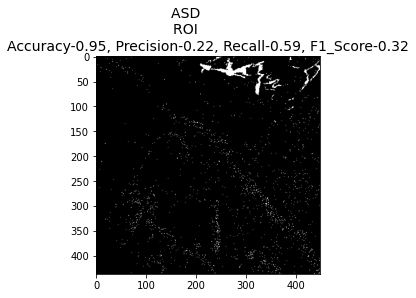

In [13]:
# For ASD we needed to use a different threshold to make it work than above
# gathering some sample background_pixels & target_pixels pixels based on euclidean distance of a pixel from target_pixels_spectrum
background_pixels, target_pixels = [], []
for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i, j, :].reshape(-1,1)
        
        # eucleadean distance between current spectral band and taregt spectrum band of the orange pixel
        target_pixels_distance = np.sqrt(np.sum(current_pixel_spectrum - avg_target_spectrum)**2)
        
        if target_pixels_distance > 1:
            background_pixels.append(ROI[i, j, :].reshape(-1,1))
        else:
            target_pixels.append(ROI[i, j, :].reshape(-1,1))

background_pixels = np.array(background_pixels)
background_pixels = background_pixels.reshape(background_pixels.shape[0], background_pixels.shape[1])
background_pixels = background_pixels.T
print("background_pixels Pixels Shape:", background_pixels.shape)

target_pixels = np.array(target_pixels)
target_pixels = target_pixels.reshape(target_pixels.shape[0], target_pixels.shape[1])
target_pixels = target_pixels.T
print("target_pixels Pixels Shape:", target_pixels.shape)


# QR Decomposition (Q.T is denoted a U in eqn 1 of paper)
Q, _ = np.linalg.qr(target_pixels)
U = Q
print("U Shape:", U.shape)

C = np.cov(target_pixels)
print("Covariance Matrix Shape:", C.shape)

try:
    C_Inv = np.linalg.inv(C)
except:
    C_Inv = np.linalg.pinv(C) # if normal inverse fails
print("Inverse Covariance Matrix Shape:", C_Inv.shape)

# this matrix (U^T * C^-1 * U) is used many times in ASD function below so creating a variable for it
mat = np.matmul(np.matmul(U.T, C_Inv), U)
print("mat Shape:", mat.shape)

ETA_THRESHOLD = 7.1e14 # needed for threshold condition of eqn 2

predictions_ASD, y_ASD, PREDS_ASD, GT_LABELS_ASD = \
    get_ASD_metrics(GT_RGB, ROI, C_Inv, U, mat, ETA_THRESHOLD, show_val=False)

# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_ASD.pkl","wb") as f:
    pkl.dump(predictions_ASD, f)
with open("./kernel_data/y_ASD.pkl","wb") as f:
    pkl.dump(y_ASD, f)
with open("./kernel_data/PREDS_ASD.pkl","wb") as f:
    pkl.dump(PREDS_ASD, f)
with open("./kernel_data/GT_LABELS_ASD.pkl","wb") as f:
    pkl.dump(GT_LABELS_ASD, f) 
    
    
# various sklearn's metric
accuracy_ASD = accuracy_score(PREDS_ASD, GT_LABELS_ASD)
precision_ASD = precision_score(PREDS_ASD, GT_LABELS_ASD)
recall_ASD = recall_score(PREDS_ASD, GT_LABELS_ASD)
f1_ASD = f1_score(PREDS_ASD, GT_LABELS_ASD)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_ASD, precision_ASD, recall_ASD, f1_ASD))

plt.imshow(predictions_ASD)
plt.title("ASD\
          \nROI\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_ASD, precision_ASD, recall_ASD, f1_ASD), size=14)

plt.savefig("./pics/ROI_ASD.png")

<a id="section2.3"></a>
## 2.3.  ASD With MNF

background_pixels Pixels Shape: (187, 195754)
target_pixels Pixels Shape: (187, 10)
U Shape: (187, 10)
Covariance Matrix Shape: (187, 187)
Inverse Covariance Matrix Shape: (187, 187)
mat Shape: (10, 10)
ROI_MNF - accuracy: 0.24, precision:0.86, recall:0.06, f1:0.11


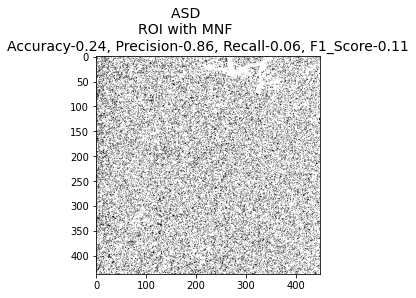

In [41]:
background_pixels, target_pixels = [], []
for i in range(ROI_MNF.shape[0]):
    for j in range(ROI_MNF.shape[1]):
        current_pixel_spectrum = ROI_MNF[i, j, :].reshape(-1,1)
        
        # eucleadean distance between current spectral band and taregt spectrum band of the orange pixel
        target_pixels_distance = np.sqrt(np.sum(current_pixel_spectrum - avg_target_spectrum_MNF)**2)
        
        if target_pixels_distance > 1:
            background_pixels.append(ROI_MNF[i, j, :].reshape(-1,1))
        else:
            target_pixels.append(ROI_MNF[i, j, :].reshape(-1,1))

background_pixels = np.array(background_pixels)
background_pixels = background_pixels.reshape(background_pixels.shape[0], background_pixels.shape[1])
background_pixels = background_pixels.T
print("background_pixels Pixels Shape:", background_pixels.shape)

target_pixels = np.array(target_pixels)
target_pixels = target_pixels.reshape(target_pixels.shape[0], target_pixels.shape[1])
target_pixels = target_pixels.T
print("target_pixels Pixels Shape:", target_pixels.shape)


# QR Decomposition (Q.T is denoted a U in eqn 1 of paper)
Q, _ = np.linalg.qr(target_pixels)
U = Q
print("U Shape:", U.shape)

C = np.cov(target_pixels)
print("Covariance Matrix Shape:", C.shape)

try:
    C_Inv = np.linalg.inv(C)
except:
    C_Inv = np.linalg.pinv(C) # if normal inverse fails
print("Inverse Covariance Matrix Shape:", C_Inv.shape)

# this matrix (U^T * C^-1 * U) is used many times in ASD function below so creating a variable for it
mat = np.matmul(np.matmul(U.T, C_Inv), U)
print("mat Shape:", mat.shape)

SHOW_VAL = True
SHOW_VAL = False
INEQUALITY_COND="gt"
# INEQUALITY_COND="lt"

ETA_THRESHOLD = 8e25 # ROI_MNF - accuracy: 0.41, precision:0.60, recall:0.06, f1:0.10
ETA_THRESHOLD = -1e25 # 9e20 # needed for threshold condition of eqn 2
ETA_THRESHOLD = -1e26 # 9e20 # needed for threshold condition of eqn 2

predictions_ASD_MNF, y_ASD_MNF, PREDS_ASD_MNF, GT_LABELS_ASD_MNF = \
    get_ASD_metrics(GT_RGB, ROI_MNF, C_Inv, U, mat, ETA_THRESHOLD, show_val=SHOW_VAL, threshold_cond=INEQUALITY_COND)

# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_ASD_MNF.pkl","wb") as f:
    pkl.dump(predictions_ASD_MNF, f)
with open("./kernel_data/y_ASD_MNF.pkl","wb") as f:
    pkl.dump(y_ASD_MNF, f)
with open("./kernel_data/PREDS_ASD_MNF.pkl","wb") as f:
    pkl.dump(PREDS_ASD_MNF, f)
with open("./kernel_data/GT_LABELS_ASD_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_ASD_MNF, f) 
    
    
# various sklearn's metric
accuracy_ASD_MNF = accuracy_score(PREDS_ASD_MNF, GT_LABELS_ASD_MNF)
precision_ASD_MNF = precision_score(PREDS_ASD_MNF, GT_LABELS_ASD_MNF)
recall_ASD_MNF = recall_score(PREDS_ASD_MNF, GT_LABELS_ASD_MNF)
f1_ASD_MNF = f1_score(PREDS_ASD_MNF, GT_LABELS_ASD_MNF)
print("ROI_MNF - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_ASD_MNF, precision_ASD_MNF, recall_ASD_MNF, f1_ASD_MNF))

plt.imshow(predictions_ASD_MNF)
plt.title("ASD\
          \nROI with MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_ASD_MNF, precision_ASD_MNF, recall_ASD_MNF, f1_ASD_MNF), size=14)

plt.savefig("./pics/ROI_ASD_MNF.png")

<a id="section3"></a>
## 3  Kernel ASD

<a id="section3.1"></a>
## 3.1.  Helper Functions

In [15]:
##### Gaussian_Radial Basis Function (GRBF) kernel #####
# width of Gaussian RBF kernel, to be determined with trial & errors
c=1e5
c=.08
def k_GRBF(x, y):                     
    norm= np.linalg.norm(x - y)
    return np.exp(-1*norm*norm/c)

###### Polynomial Kernel.#####
d= 5 #power parameter of polynomial kernel, tbd
theta= 1 #constant term for polynomial kernel, tbd

def k_poly(x,y):                        
    return np.power(np.dot(x,y.T)+theta, d)


##### Spectral angle_based kernel. #####
def k_spectral(x, y):        
    norm_x= np.linalg.norm(x)
    norm_y= np.linalg.norm(y)
    dot= x.dot(y.T)
    return dot/(norm_x*norm_y)


# K(x, Y)
def calculate_K_x_X(kernel, x, background, center_data):
    arr_ = []
    for i in range(background.shape[0]):
        val = kernel(background[i,:].reshape(1,-1), x.reshape(1,-1))
        arr_.append(val)
    
    center = [(1/background.shape[0])*sum(arr_)]*len(arr_)
    center = np.array(center).reshape(-1,1)
    
    arr_ = np.array(arr_).reshape(-1,1)
    
    if center_data:
        arr_ = arr_ - center
    return arr_


# K(X,X), K_Inv, k_Inv2 (eqn 13)
def gram_matrix_background(kernel, background, center_data):
    # Kernel/Gram Matrix for background pixels
    K_XX = np.zeros((background.shape[0], background.shape[0])) # K(Y,Y) the gram matrix
    for i in range(K_XX.shape[0]):
        for j in range(K_XX.shape[1]):
            K_XX[i,j] = kernel(background[i,:].reshape(1,-1), background[j,:].reshape(1,-1))
    print("Background Kernel Matrix Shape:", K_XX.shape)

    # if want to center K_XX
    if center_data:
        arr_ = [1.0/background.shape[0]]*background.shape[0]
        arr_ = np.array(arr_)
        i_N = np.diag(arr_)
        K_XX = K_XX - np.matmul(i_N, K_XX) - np.matmul(K_XX, i_N) + np.matmul(np.matmul(i_N, K_XX), i_N)

    try:
        K_Inv = np.linalg.inv(K_XX)
    except:
        K_Inv = np.linalg.pinv(K_XX) # calculating pseudo inverse if normal inverse gave errors

    K_Inv2 = np.matmul(K_Inv, K_Inv)
    print("K_Inv2 Shape", K_Inv2.shape)

    return K_XX, K_Inv, K_Inv2

def gram_matrix_target(kernel, independent_targets):

    # Kernel/Gram Matrix for independent target pixels
    K_YY = np.zeros((independent_targets.shape[0], independent_targets.shape[0])) # K(Y,Y) the gram matrix
    for i in range(K_YY.shape[0]):
        for j in range(K_YY.shape[1]):
            K_YY[i,j] = kernel(independent_targets[i,:].reshape(1,-1), independent_targets[j,:].reshape(1,-1))
    
    print("Independent Target Kernel Matrix Shape:", K_YY.shape)
    eigenvectors, eigenmat = np.linalg.eig(K_YY)
    eigen_diag = np.diag(eigenvectors**-.5)
    Tau = np.matmul(eigenmat, eigen_diag)
    
    return Tau


def get_K_XY(kernel, background, independent_targets, center_data):
    # K(X,Y)
    K_XY = np.zeros((background.shape[0], independent_targets.shape[0]))
    for i in range(background.shape[0]):
        for j in range(independent_targets.shape[0]):
            K_XY[i,j] = kernel(background[i,:].reshape(1,-1), independent_targets[j,:].reshape(1,-1))
    print("K_XY Shape:", K_XY.shape)

    # if want to center K(X,Y)
    if center_data:
        
        arr_ = [1.0/background.shape[0]]*background.shape[0]
        arr_ = np.array(arr_)
        i_N = np.diag(arr_)
        
        arr_ = [1.0/independent_targets.shape[0]]*independent_targets.shape[0]
        arr_ = np.array(arr_)
        i_M = np.diag(arr_)
        
        K_XY = K_XY - np.matmul(i_N, K_XY) - np.matmul(K_XY, i_M) + np.matmul(np.matmul(i_N, K_XY), i_M)
        
    return K_XY



def Kernel_ASD(j, kernel_func, x, background, K_T, mat, K_Inv2, center_data):
    # eqn 18
    vec = calculate_K_x_X(kernel_func, x, background, center_data)
    
    Kx_T = np.matmul(K_T, vec)
    Kx   = Kx_T.T
    numerator = np.matmul(Kx,mat)
    numerator = np.matmul(numerator, Kx_T)
    
    # denomiator
    K_x_X = vec #calculate_K_x_X(x)
    K_x_X_T = K_x_X.reshape(1,-1)
#     K_x_X_T =  vec.reshape(1,-1)    
    denominator = np.matmul(K_x_X_T, K_Inv2)
    denominator = np.matmul(denominator, K_x_X)
    denominator += 1e-5 # to avoid zero division
    
    ratio = numerator/denominator
    
    return [j, ratio]

def kernel_ASD_metrics(GT_RGB, roi, background, K_T, mat, K_Inv2, kernel="gaussian", 
                       center_data=True, show_val=False, threshold_cond="gt"):
    
    # Generate predictions from KASD method for ROI
    predictions_KASD = np.zeros((roi.shape[0],roi.shape[1],3))
    y_KASD = []
    PREDS_KASD, GT_LABELS_KASD = [], []
    
    if kernel=="gaussian":
        kernel_func = k_GRBF
    elif kernel=="polynomial":
        kernel_func = k_poly
    else:
        kernel_func = k_spectral
    
    for i in range(ROI.shape[0]):
        with parallel_backend('threading', n_jobs=5):
            list_results = Parallel()(delayed(Kernel_ASD)(j, kernel_func, roi[i,j,:], background, K_T, mat, K_Inv2, center_data)
                                                          for j in range(roi.shape[1]))
        list_results.sort(key = lambda x: x[0])
        
        for j in range(roi.shape[1]):
            y = list_results[j][1]
            y = y[0][0]
            
            if show_val:
                print(y)

            if threshold_cond=="gt":
                if y >= ETA_THRESHOLD:
                    predictions_KASD[i,j,:] = 0
                else:
                    predictions_KASD[i,j,:] = 1
            else:
                if y <= ETA_THRESHOLD:
                    predictions_KASD[i,j,:] = 0
                else:
                    predictions_KASD[i,j,:] = 1
            
            # save y value for thresholding for ROC curve later
            y_KASD.append(y)

            # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
            gt = sum(GT_RGB[i,j,:])
            if gt == 0.0:
                GT_LABELS_KASD.append(0)
            else:
                GT_LABELS_KASD.append(1)

            pred = sum(predictions_KASD[i,j,:])            
            if pred == 0.0:
                PREDS_KASD.append(0)
            else:
                PREDS_KASD.append(1)
                
    return predictions_KASD, y_KASD, PREDS_KASD, GT_LABELS_KASD

<a id="section4"></a>
## 4  KASD (Gaussian Kernel)

<a id="section4.1"></a>
## 4.1.  KASD (Gaussian Kernel) without MNF

In [27]:
background = centroids_background

# CENTER_DATA = True
CENTER_DATA = False

SHOW_VAL = True
SHOW_VAL = False

INEQUALITY_COND = "gt"
# INEQUALITY_COND = "lt"

# ETA_THRESHOLD = 7
ETA_THRESHOLD = 1.5e3
ETA_THRESHOLD = 100 #700 ROI - accuracy: 0.49, precision:0.70, recall:0.07, f1:0.13
ETA_THRESHOLD = 20 # ROI - accuracy: 0.50, precision:0.59, recall:0.06, f1:0.12
ETA_THRESHOLD = 10

K_XX, K_Inv, K_Inv2 = gram_matrix_background(k_GRBF, background, CENTER_DATA)

K_XY = get_K_XY(k_GRBF, background, independent_targets, CENTER_DATA)

Tau = gram_matrix_target(k_GRBF, independent_targets)

# eqn 19
K_T = np.matmul(Tau.T, K_XY.T)
K_T = np.matmul(K_T, K_Inv2)
print("K_T Shape:", K_T.shape)

# matrix eqn 20
mat = np.matmul(Tau.T, K_XY.T)
mat = np.matmul(mat, K_Inv2)
mat = np.matmul(mat, K_XY)
mat = np.matmul(mat, Tau)
try:
    mat = np.linalg.inv(mat)
except:
    mat = np.linalg.pinv(mat)
print("mat shape:", mat.shape)

predictions_KASD_Gaussian, y_KASD_Gaussian, PREDS_KASD_Gaussian, GT_LABELS_KASD_Gaussian = \
kernel_ASD_metrics(GT_RGB, ROI, background, K_T, mat, K_Inv2, kernel="gaussian", 
                   center_data=CENTER_DATA, show_val=SHOW_VAL, threshold_cond=INEQUALITY_COND)

# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KASD_Gaussian.pkl","wb") as f:
    pkl.dump(predictions_KASD_Gaussian, f)
with open("./kernel_data/y_KASD_Gaussian.pkl","wb") as f:
    pkl.dump(y_KASD_Gaussian, f)
with open("./kernel_data/PREDS_KASD_Gaussian.pkl","wb") as f:
    pkl.dump(PREDS_KASD_Gaussian, f)
with open("./kernel_data/GT_LABELS_KASD_Gaussian.pkl","wb") as f:
    pkl.dump(GT_LABELS_KASD_Gaussian, f)  

Background Kernel Matrix Shape: (300, 300)
K_Inv2 Shape (300, 300)
K_XY Shape: (300, 187)
Independent Target Kernel Matrix Shape: (187, 187)
K_T Shape: (187, 300)
mat shape: (187, 187)


ROI - accuracy: 0.50, precision:0.55, recall:0.06, f1:0.11


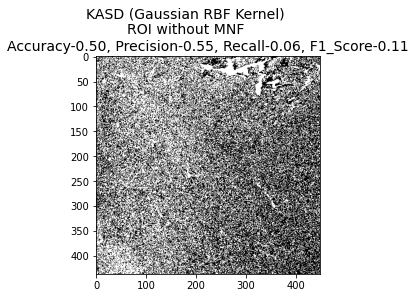

In [28]:
# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KASD_Gaussian.pkl","rb") as f:
    predictions_KASD_Gaussian = pkl.load(f)
with open("./kernel_data/y_KASD_Gaussian.pkl","rb") as f:
    y_KASD_Gaussian = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Gaussian.pkl","rb") as f:
    PREDS_KASD_Gaussian = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Gaussian.pkl","rb") as f:
    GT_LABELS_KASD_Gaussian = pkl.load(f)

# various sklearn's metric
accuracy_KASD_Gaussian = accuracy_score(PREDS_KASD_Gaussian, GT_LABELS_KASD_Gaussian)
precision_KASD_Gaussian = precision_score(PREDS_KASD_Gaussian, GT_LABELS_KASD_Gaussian)
recall_KASD_Gaussian = recall_score(PREDS_KASD_Gaussian, GT_LABELS_KASD_Gaussian)
f1_KASD_Gaussian = f1_score(PREDS_KASD_Gaussian, GT_LABELS_KASD_Gaussian)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_KASD_Gaussian, precision_KASD_Gaussian, recall_KASD_Gaussian, f1_KASD_Gaussian))

plt.imshow(predictions_KASD_Gaussian)
plt.title("KASD (Gaussian RBF Kernel)\
          \nROI without MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_KASD_Gaussian, precision_KASD_Gaussian, recall_KASD_Gaussian, f1_KASD_Gaussian), size=14)

plt.savefig("./pics/ROI_KASD_GaussianRBFKernel.png")

<a id="section4.2"></a>
## 4.2.  KASD (Gaussian Kernel) with MNF

In [8]:
background = centroids_background_MNF
independent_targets = independent_targets_MNF

# CENTER_DATA = True
CENTER_DATA = False

ETA_THRESHOLD = 9e4

# SHOW_VAL = True
SHOW_VAL = False

# INEQUALITY_COND="gt"
INEQUALITY_COND="lt"


K_XX, K_Inv, K_Inv2 = gram_matrix_background(k_GRBF, background, CENTER_DATA)

K_XY = get_K_XY(k_GRBF, background, independent_targets, CENTER_DATA)

Tau = gram_matrix_target(k_GRBF, independent_targets)

# eqn 19
K_T = np.matmul(Tau.T, K_XY.T)
K_T = np.matmul(K_T, K_Inv2)
print("K_T Shape:", K_T.shape)

# matrix eqn 20
mat = np.matmul(Tau.T, K_XY.T)
mat = np.matmul(mat, K_Inv2)
mat = np.matmul(mat, K_XY)
mat = np.matmul(mat, Tau)
try:
    mat = np.linalg.inv(mat)
except:
    mat = np.linalg.pinv(mat)
print("mat shape:", mat.shape)

predictions_KASD_Gaussian_MNF, y_KASD_Gaussian_MNF, PREDS_KASD_Gaussian_MNF, GT_LABELS_KASD_Gaussian_MNF = \
kernel_ASD_metrics(GT_RGB, ROI, background, K_T, mat, K_Inv2, kernel="gaussian", 
                   center_data=CENTER_DATA, show_val=SHOW_VAL, threshold_cond=INEQUALITY_COND)

# let's save these so as to directly load later rather than rerun the code
with open("./kernel_data/predictions_KASD_Gaussian_MNF.pkl","wb") as f:
    pkl.dump(predictions_KASD_Gaussian_MNF, f)
with open("./kernel_data/y_KASD_Gaussian_MNF.pkl","wb") as f:
    pkl.dump(y_KASD_Gaussian_MNF, f)
with open("./kernel_data/PREDS_KASD_Gaussian_MNF.pkl","wb") as f:
    pkl.dump(PREDS_KASD_Gaussian_MNF, f)
with open("./kernel_data/GT_LABELS_KASD_Gaussian_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_KASD_Gaussian_MNF, f)  

Background Kernel Matrix Shape: (300, 300)
K_Inv2 Shape (300, 300)
K_XY Shape: (300, 187)
Independent Target Kernel Matrix Shape: (187, 187)
K_T Shape: (187, 300)
mat shape: (187, 187)


ROI - accuracy: 0.96, precision:0.33, recall:0.98, f1:0.50


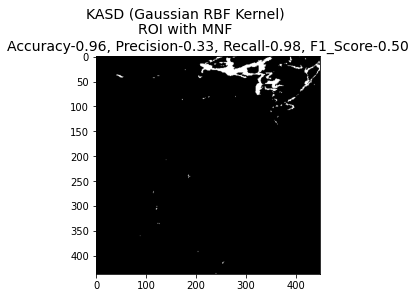

In [9]:
# reload & plot
with open("./kernel_data/predictions_KASD_Gaussian_MNF.pkl","rb") as f:
    predictions_KASD_Gaussian_MNF = pkl.load(f)
with open("./kernel_data/y_KASD_Gaussian_MNF.pkl","rb") as f:
    y_KASD_Gaussian_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Gaussian_MNF.pkl","rb") as f:
    PREDS_KASD_Gaussian_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Gaussian_MNF.pkl","rb") as f:
    GT_LABELS_KASD_Gaussian_MNF = pkl.load(f) 
    
# various sklearn's metric
accuracy_KASD_Gaussian_MNF = accuracy_score(PREDS_KASD_Gaussian_MNF, GT_LABELS_KASD_Gaussian_MNF)
precision_KASD_Gaussian_MNF = precision_score(PREDS_KASD_Gaussian_MNF, GT_LABELS_KASD_Gaussian_MNF)
recall_KASD_Gaussian_MNF = recall_score(PREDS_KASD_Gaussian_MNF, GT_LABELS_KASD_Gaussian_MNF)
f1_KASD_Gaussian_MNF = f1_score(PREDS_KASD_Gaussian_MNF, GT_LABELS_KASD_Gaussian_MNF)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_KASD_Gaussian_MNF, precision_KASD_Gaussian_MNF, recall_KASD_Gaussian_MNF, f1_KASD_Gaussian_MNF))

plt.imshow(predictions_KASD_Gaussian_MNF)
plt.title("KASD (Gaussian RBF Kernel)\
          \nROI with MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_KASD_Gaussian_MNF, precision_KASD_Gaussian_MNF, recall_KASD_Gaussian_MNF, f1_KASD_Gaussian_MNF), size=14)

plt.savefig("./pics/ROI_KASD_Gaussian_MNF.png")

<a id="section5"></a>
## 5.  KASD (Polynomial Kernel)

<a id="section5.1"></a>
## 5.1.  KASD (Polynomial) without MNF

In [11]:
background = centroids_background

# CENTER_DATA = True
CENTER_DATA = False

SHOW_VAL = True
SHOW_VAL = False

# INEQUALITY_COND="gt"
INEQUALITY_COND="lt"

ETA_THRESHOLD = .976

K_XX, K_Inv, K_Inv2 = gram_matrix_background(k_poly, background, CENTER_DATA)

K_XY = get_K_XY(k_poly, background, independent_targets, CENTER_DATA)

Tau = gram_matrix_target(k_poly, independent_targets)

# eqn 19
K_T = np.matmul(Tau.T, K_XY.T)
K_T = np.matmul(K_T, K_Inv2)
print("K_T Shape:", K_T.shape)

# matrix eqn 20
mat = np.matmul(Tau.T, K_XY.T)
mat = np.matmul(mat, K_Inv2)
mat = np.matmul(mat, K_XY)
mat = np.matmul(mat, Tau)
try:
    mat = np.linalg.inv(mat)
except:
    mat = np.linalg.pinv(mat)
print("mat shape:", mat.shape)

predictions_KASD_Polynomial, y_KASD_Polynomial, PREDS_KASD_Polynomial, GT_LABELS_KASD_Polynomial = \
kernel_ASD_metrics(GT_RGB, ROI, background, K_T, mat, K_Inv2, kernel="poly", 
                   center_data=CENTER_DATA, show_val=SHOW_VAL, threshold_cond=INEQUALITY_COND)

# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KASD_Polynomial.pkl","wb") as f:
    pkl.dump(predictions_KASD_Polynomial, f)
with open("./kernel_data/y_KASD_Polynomial.pkl","wb") as f:
    pkl.dump(y_KASD_Polynomial, f)
with open("./kernel_data/PREDS_KASD_Polynomial.pkl","wb") as f:
    pkl.dump(PREDS_KASD_Polynomial, f)
with open("./kernel_data/GT_LABELS_KASD_Polynomial.pkl","wb") as f:
    pkl.dump(GT_LABELS_KASD_Polynomial, f)  

Background Kernel Matrix Shape: (300, 300)
K_Inv2 Shape (300, 300)
K_XY Shape: (300, 187)
Independent Target Kernel Matrix Shape: (187, 187)
K_T Shape: (187, 300)
mat shape: (187, 187)


ROI - accuracy: 0.85, precision:0.76, recall:0.23, f1:0.36


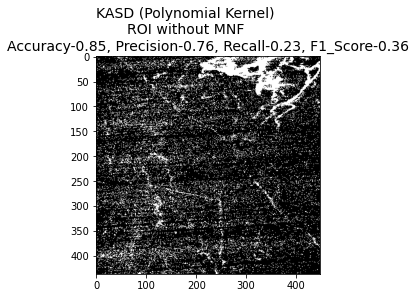

In [12]:
# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KASD_Polynomial.pkl","rb") as f:
    predictions_KASD_Polynomial = pkl.load(f)
with open("./kernel_data/y_KASD_Polynomial.pkl","rb") as f:
    y_KASD_Polynomial = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Polynomial.pkl","rb") as f:
    PREDS_KASD_Polynomial = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Polynomial.pkl","rb") as f:
    GT_LABELS_KASD_Polynomial = pkl.load(f )

# various sklearn's metric
accuracy_KASD_Polynomial = accuracy_score(PREDS_KASD_Polynomial, GT_LABELS_KASD_Polynomial)
precision_KASD_Polynomial = precision_score(PREDS_KASD_Polynomial, GT_LABELS_KASD_Polynomial)
recall_KASD_Polynomial = recall_score(PREDS_KASD_Polynomial, GT_LABELS_KASD_Polynomial)
f1_KASD_Polynomial = f1_score(PREDS_KASD_Polynomial, GT_LABELS_KASD_Polynomial)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_KASD_Polynomial, precision_KASD_Polynomial, recall_KASD_Polynomial, f1_KASD_Polynomial))

plt.imshow(predictions_KASD_Polynomial)
plt.title("KASD (Polynomial Kernel)\
          \nROI without MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_KASD_Polynomial, precision_KASD_Polynomial, recall_KASD_Polynomial, f1_KASD_Polynomial), size=14)

plt.savefig("./pics/ROI_KASD_Polynomial.png")

<a id="section5.2"></a>
## 5.2.  KASD (Polynomial) with MNF

In [14]:
background = centroids_background_MNF
independent_targets = independent_targets_MNF

CENTER_DATA = True
CENTER_DATA = False

SHOW_VAL = True
SHOW_VAL = False

INEQUALITY_COND="gt"
# INEQUALITY_COND="lt"

ETA_THRESHOLD = 3e-25

K_XX, K_Inv, K_Inv2 = gram_matrix_background(k_poly, background, CENTER_DATA)

K_XY = get_K_XY(k_poly, background, independent_targets, CENTER_DATA)

Tau = gram_matrix_target(k_poly, independent_targets)

# eqn 19
K_T = np.matmul(Tau.T, K_XY.T)
K_T = np.matmul(K_T, K_Inv2)
print("K_T Shape:", K_T.shape)

# matrix eqn 20
mat = np.matmul(Tau.T, K_XY.T)
mat = np.matmul(mat, K_Inv2)
mat = np.matmul(mat, K_XY)
mat = np.matmul(mat, Tau)
try:
    mat = np.linalg.inv(mat)
except:
    mat = np.linalg.pinv(mat)
print("mat shape:", mat.shape)

predictions_KASD_Polynomial_MNF, y_KASD_Polynomial_MNF, PREDS_KASD_Polynomial_MNF, GT_LABELS_KASD_Polynomial_MNF = \
kernel_ASD_metrics(GT_RGB, ROI, background, K_T, mat, K_Inv2, kernel="poly", 
                   center_data=CENTER_DATA, show_val=SHOW_VAL, threshold_cond=INEQUALITY_COND)

# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KASD_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(predictions_KASD_Polynomial_MNF, f)
with open("./kernel_data/y_KASD_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(y_KASD_Polynomial_MNF, f)
with open("./kernel_data/PREDS_KASD_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(PREDS_KASD_Polynomial_MNF, f)
with open("./kernel_data/GT_LABELS_KASD_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_KASD_Polynomial_MNF, f)  

Background Kernel Matrix Shape: (300, 300)
K_Inv2 Shape (300, 300)
K_XY Shape: (300, 187)
Independent Target Kernel Matrix Shape: (187, 187)
K_T Shape: (187, 300)
mat shape: (187, 187)


ROI - accuracy: 0.62, precision:0.54, recall:0.08, f1:0.14


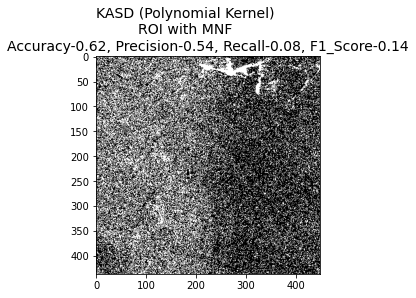

In [11]:
# reload & plot
with open("./kernel_data/predictions_KASD_Polynomial_MNF.pkl","rb") as f:
    predictions_KASD_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/y_KASD_Polynomial_MNF.pkl","rb") as f:
    y_KASD_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Polynomial_MNF.pkl","rb") as f:
    PREDS_KASD_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Polynomial_MNF.pkl","rb") as f:
    GT_LABELS_KASD_Polynomial_MNF = pkl.load(f) 
    
# various sklearn's metric
accuracy_KASD_Polynomial_MNF = accuracy_score(PREDS_KASD_Polynomial_MNF, GT_LABELS_KASD_Polynomial_MNF)
precision_KASD_Polynomial_MNF = precision_score(PREDS_KASD_Polynomial_MNF, GT_LABELS_KASD_Polynomial_MNF)
recall_KASD_Polynomial_MNF = recall_score(PREDS_KASD_Polynomial_MNF, GT_LABELS_KASD_Polynomial_MNF)
f1_KASD_Polynomial_MNF = f1_score(PREDS_KASD_Polynomial_MNF, GT_LABELS_KASD_Polynomial_MNF)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_KASD_Polynomial_MNF, precision_KASD_Polynomial_MNF, recall_KASD_Polynomial_MNF, f1_KASD_Polynomial_MNF))

plt.imshow(predictions_KASD_Polynomial_MNF)
plt.title("KASD (Polynomial Kernel)\
          \nROI with MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_KASD_Polynomial_MNF, precision_KASD_Polynomial_MNF, recall_KASD_Polynomial_MNF, f1_KASD_Polynomial_MNF), size=14)

plt.savefig("./pics/ROI_KASD_Polynomial_MNF.png")

<a id="section6"></a>
## 6.  KASD (Spectral Angle)

<a id="section6.1"></a>
## 6.1.  KASD (Spectral Angle Kernel) without MNF

In [15]:
background = centroids_background

# CENTER_DATA = True
CENTER_DATA = False

SHOW_VAL = True
SHOW_VAL = False

# INEQUALITY_COND="gt"
INEQUALITY_COND="lt"

ETA_THRESHOLD = .98

K_XX, K_Inv, K_Inv2 = gram_matrix_background(k_spectral, background, CENTER_DATA)

K_XY = get_K_XY(k_spectral, background, independent_targets, CENTER_DATA)

Tau = gram_matrix_target(k_spectral, independent_targets)

# eqn 19
K_T = np.matmul(Tau.T, K_XY.T)
K_T = np.matmul(K_T, K_Inv2)
print("K_T Shape:", K_T.shape)

# matrix eqn 20
mat = np.matmul(Tau.T, K_XY.T)
mat = np.matmul(mat, K_Inv2)
mat = np.matmul(mat, K_XY)
mat = np.matmul(mat, Tau)
try:
    mat = np.linalg.inv(mat)
except:
    mat = np.linalg.pinv(mat)
print("mat shape:", mat.shape)

predictions_KASD_Spectral, y_KASD_Spectral, PREDS_KASD_Spectral, GT_LABELS_KASD_Spectral = \
kernel_ASD_metrics(GT_RGB, ROI, background, K_T, mat, K_Inv2, kernel="spectral", 
                   center_data=CENTER_DATA, show_val=SHOW_VAL, threshold_cond=INEQUALITY_COND)

# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KASD_Spectral.pkl","wb") as f:
    pkl.dump(predictions_KASD_Spectral, f)
with open("./kernel_data/y_KASD_Spectral.pkl","wb") as f:
    pkl.dump(y_KASD_Spectral, f)
with open("./kernel_data/PREDS_KASD_Spectral.pkl","wb") as f:
    pkl.dump(PREDS_KASD_Spectral, f)
with open("./kernel_data/GT_LABELS_KASD_Spectral.pkl","wb") as f:
    pkl.dump(GT_LABELS_KASD_Spectral, f)  

Background Kernel Matrix Shape: (300, 300)
K_Inv2 Shape (300, 300)
K_XY Shape: (300, 187)
Independent Target Kernel Matrix Shape: (187, 187)
K_T Shape: (187, 300)
mat shape: (187, 187)


ROI - accuracy: 0.96, precision:0.29, recall:0.99, f1:0.45


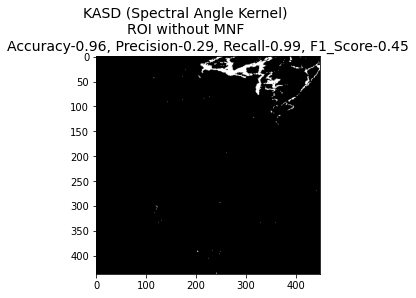

In [9]:
# reload & plot
with open("./kernel_data/predictions_KASD_Spectral.pkl","rb") as f:
    predictions_KASD_Spectral = pkl.load(f)
with open("./kernel_data/y_KASD_Spectral.pkl","rb") as f:
    y_KASD_Spectral = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Spectral.pkl","rb") as f:
    PREDS_KASD_Spectral = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Spectral.pkl","rb") as f:
    GT_LABELS_KASD_Spectral = pkl.load(f)

# various sklearn's metric
accuracy_KASD_Spectral = accuracy_score(PREDS_KASD_Spectral, GT_LABELS_KASD_Spectral)
precision_KASD_Spectral = precision_score(PREDS_KASD_Spectral, GT_LABELS_KASD_Spectral)
recall_KASD_Spectral = recall_score(PREDS_KASD_Spectral, GT_LABELS_KASD_Spectral)
f1_KASD_Spectral = f1_score(PREDS_KASD_Spectral, GT_LABELS_KASD_Spectral)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_KASD_Spectral, precision_KASD_Spectral, recall_KASD_Spectral, f1_KASD_Spectral))

plt.imshow(predictions_KASD_Spectral)
plt.title("KASD (Spectral Angle Kernel)\
          \nROI without MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_KASD_Spectral, precision_KASD_Spectral, recall_KASD_Spectral, f1_KASD_Spectral), size=14)

plt.savefig("./pics/ROI_KASD_Spectral.png")

<a id="section6.2"></a>
## 6.2.  KASD (Spectral Angle Kernel) with MNF

In [ ]:
background = centroids_background_MNF
independent_targets = independent_targets_MNF

# CENTER_DATA = True
CENTER_DATA = False

SHOW_VAL = True
SHOW_VAL = False

# INEQUALITY_COND="gt"
INEQUALITY_COND="lt"

# INEQUALITY_COND="gt"
INEQUALITY_COND="lt"

ETA_THRESHOLD = .976
ETA_THRESHOLD = 1e-26

K_XX, K_Inv, K_Inv2 = gram_matrix_background(k_spectral, background, CENTER_DATA)

K_XY = get_K_XY(k_spectral, background, independent_targets, CENTER_DATA)

Tau = gram_matrix_target(k_spectral, independent_targets)

# eqn 19
K_T = np.matmul(Tau.T, K_XY.T)
K_T = np.matmul(K_T, K_Inv2)
print("K_T Shape:", K_T.shape)

# matrix eqn 20
mat = np.matmul(Tau.T, K_XY.T)
mat = np.matmul(mat, K_Inv2)
mat = np.matmul(mat, K_XY)
mat = np.matmul(mat, Tau)
try:
    mat = np.linalg.inv(mat)
except:
    mat = np.linalg.pinv(mat)
print("mat shape:", mat.shape)

predictions_KASD_Spectral_MNF, y_KASD_Spectral_MNF, PREDS_KASD_Spectral_MNF, GT_LABELS_KASD_Spectral_MNF = \
kernel_ASD_metrics(GT_RGB, ROI, background, K_T, mat, K_Inv2, kernel="spectral", 
                   center_data=CENTER_DATA, show_val=SHOW_VAL, threshold_cond=INEQUALITY_COND)

# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KASD_Spectral_MNF.pkl","wb") as f:
    pkl.dump(predictions_KASD_Spectral_MNF, f)
with open("./kernel_data/y_KASD_Spectral_MNF.pkl","wb") as f:
    pkl.dump(y_KASD_Spectral_MNF, f)
with open("./kernel_data/PREDS_KASD_Spectral_MNF.pkl","wb") as f:
    pkl.dump(PREDS_KASD_Spectral_MNF, f)
with open("./kernel_data/GT_LABELS_KASD_Spectral_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_KASD_Spectral_MNF, f)  

ROI - accuracy: 0.78, precision:0.23, recall:0.07, f1:0.10


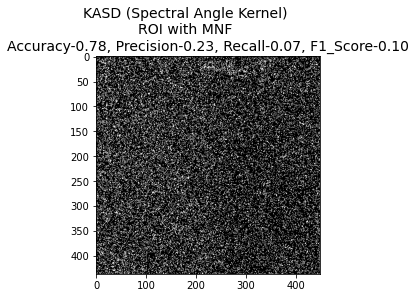

In [8]:
# reload & plot
with open("./kernel_data/predictions_KASD_Spectral_MNF.pkl","rb") as f:
    predictions_KASD_Spectral_MNF = pkl.load(f)
with open("./kernel_data/y_KASD_Spectral_MNF.pkl","rb") as f:
    y_KASD_Spectral_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Spectral_MNF.pkl","rb") as f:
    PREDS_KASD_Spectral_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Spectral_MNF.pkl","rb") as f:
    GT_LABELS_KASD_Spectral_MNF = pkl.load(f)

# various sklearn's metric
accuracy_KASD_Spectral_MNF = accuracy_score(PREDS_KASD_Spectral_MNF, GT_LABELS_KASD_Spectral_MNF)
precision_KASD_Spectral_MNF = precision_score(PREDS_KASD_Spectral_MNF, GT_LABELS_KASD_Spectral_MNF)
recall_KASD_Spectral_MNF = recall_score(PREDS_KASD_Spectral_MNF, GT_LABELS_KASD_Spectral_MNF)
f1_KASD_Spectral_MNF = f1_score(PREDS_KASD_Spectral_MNF, GT_LABELS_KASD_Spectral_MNF)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_KASD_Spectral_MNF, precision_KASD_Spectral_MNF, recall_KASD_Spectral_MNF, f1_KASD_Spectral_MNF))

plt.imshow(predictions_KASD_Spectral_MNF)
plt.title("KASD (Spectral Angle Kernel)\
          \nROI with MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_KASD_Spectral_MNF, precision_KASD_Spectral_MNF, recall_KASD_Spectral_MNF, f1_KASD_Spectral_MNF), size=14)

plt.savefig("./pics/ROI_KASD_Spectral_MNF.png")

<a id="section7"></a>
## 7.  Combined Plot

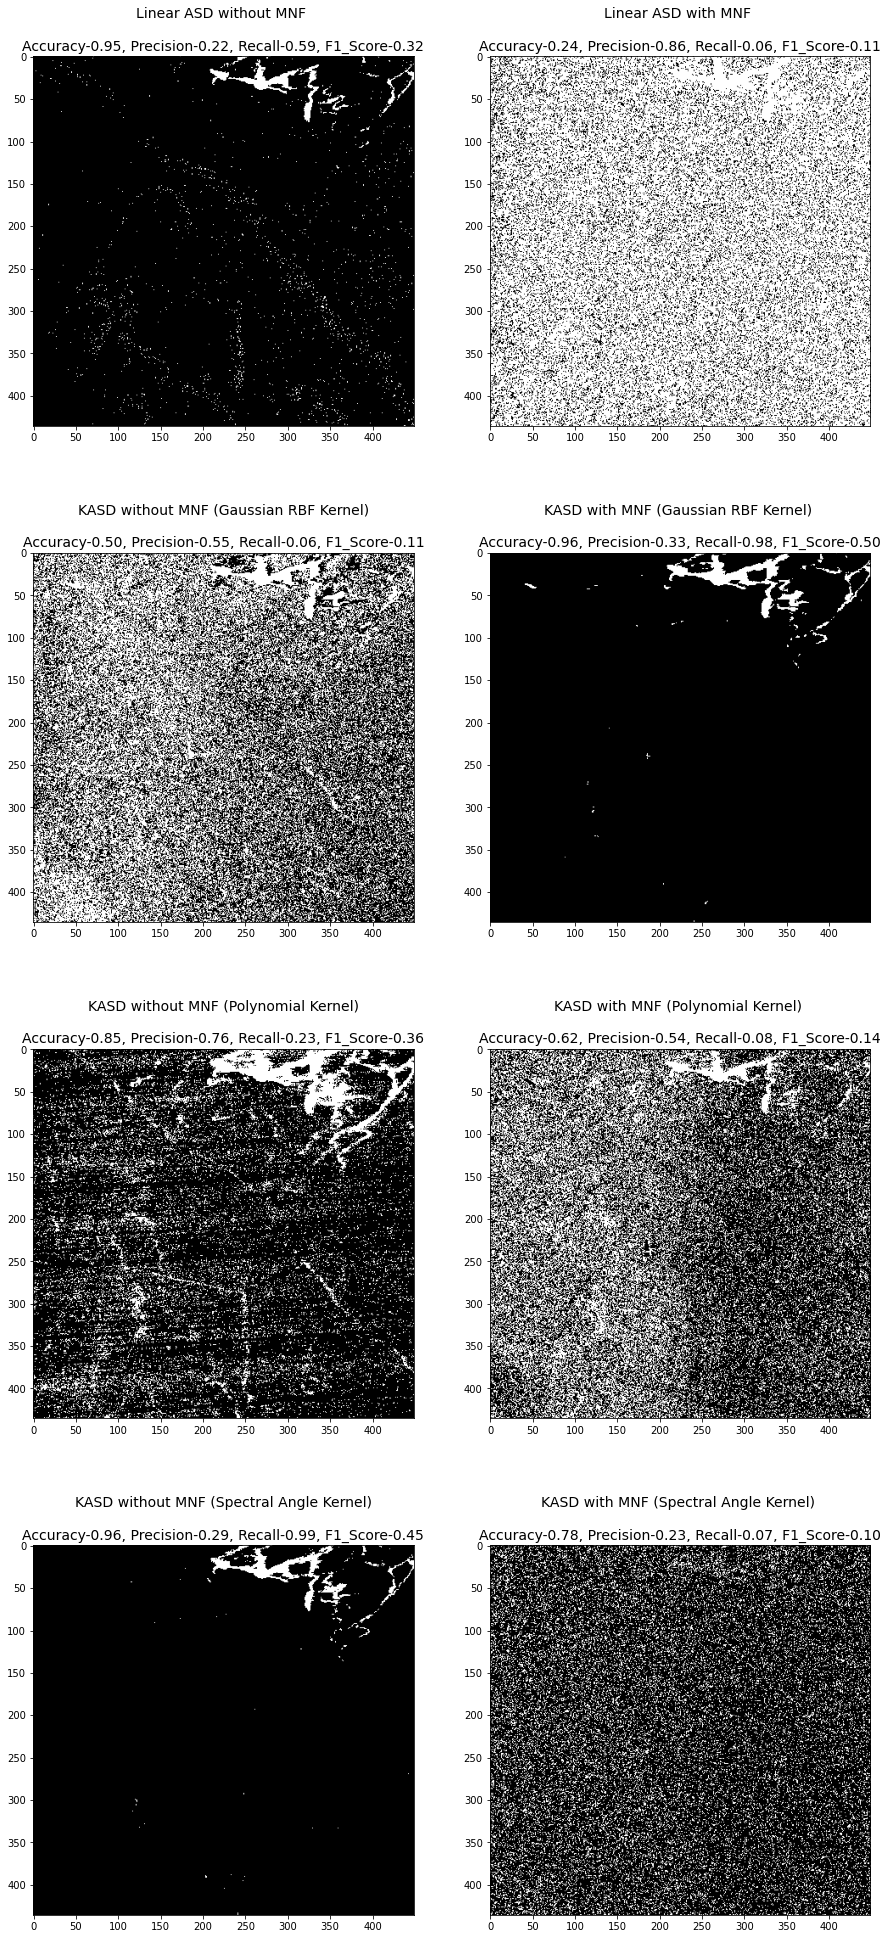

In [10]:
# plt.figure(figsize=(20,15))

plt.figure(figsize=(15,35))

###################################### Linear ASD ###########################################################
plt.subplot(421)
with open("./kernel_data/predictions_ASD.pkl","rb") as f:
    predictions_ASD = pkl.load(f)
with open("./kernel_data/PREDS_ASD.pkl","rb") as f:
    PREDS_ASD = pkl.load(f)
with open("./kernel_data/GT_LABELS_ASD.pkl","rb") as f:
    GT_LABELS_ASD = pkl.load(f)
    
accuracy = accuracy_score(PREDS_ASD, GT_LABELS_ASD)
precision = precision_score(PREDS_ASD, GT_LABELS_ASD)
recall = recall_score(PREDS_ASD, GT_LABELS_ASD)
f1 = f1_score(PREDS_ASD, GT_LABELS_ASD)

plt.imshow(predictions_ASD)
plt.title("Linear ASD without MNF \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(422)
with open("./kernel_data/predictions_ASD_MNF.pkl","rb") as f:
    predictions_ASD_MNF = pkl.load(f)
with open("./kernel_data/PREDS_ASD_MNF.pkl","rb") as f:
    PREDS_ASD_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_ASD_MNF.pkl","rb") as f:
    GT_LABELS_ASD_MNF = pkl.load(f)

accuracy = accuracy_score(PREDS_ASD_MNF, GT_LABELS_ASD_MNF)
precision = precision_score(PREDS_ASD_MNF, GT_LABELS_ASD_MNF)
recall = recall_score(PREDS_ASD_MNF, GT_LABELS_ASD_MNF)
f1 = f1_score(PREDS_ASD_MNF, GT_LABELS_ASD_MNF)

plt.imshow(predictions_ASD_MNF)
plt.title("Linear ASD with MNF \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################
    
###################################### Gaussian RBF Kernel ###########################################################
plt.subplot(423)
with open("./kernel_data/predictions_KASD_Gaussian.pkl","rb") as f:
    predictions_KASD_Gaussian = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Gaussian.pkl","rb") as f:
    PREDS_KASD_Gaussian = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Gaussian.pkl","rb") as f:
    GT_LABELS_KASD_Gaussian = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KASD_Gaussian, GT_LABELS_KASD_Gaussian)
precision = precision_score(PREDS_KASD_Gaussian, GT_LABELS_KASD_Gaussian)
recall = recall_score(PREDS_KASD_Gaussian, GT_LABELS_KASD_Gaussian)
f1 = f1_score(PREDS_KASD_Gaussian, GT_LABELS_KASD_Gaussian)

plt.imshow(predictions_KASD_Gaussian)
plt.title("\nKASD without MNF (Gaussian RBF Kernel)\
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(424)
with open("./kernel_data/predictions_KASD_Gaussian_MNF.pkl","rb") as f:
    predictions_KASD_Gaussian_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Gaussian_MNF.pkl","rb") as f:
    PREDS_KASD_Gaussian_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Gaussian_MNF.pkl","rb") as f:
    GT_LABELS_KASD_Gaussian_MNF = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KASD_Gaussian_MNF, GT_LABELS_KASD_Gaussian_MNF)
precision = precision_score(PREDS_KASD_Gaussian_MNF, GT_LABELS_KASD_Gaussian_MNF)
recall = recall_score(PREDS_KASD_Gaussian_MNF, GT_LABELS_KASD_Gaussian_MNF)
f1 = f1_score(PREDS_KASD_Gaussian_MNF, GT_LABELS_KASD_Gaussian_MNF)

plt.imshow(predictions_KASD_Gaussian_MNF)
plt.title("\nKASD with MNF (Gaussian RBF Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################

###################################### Polynomial Kernel ###########################################################
plt.subplot(425)
with open("./kernel_data/predictions_KASD_Polynomial.pkl","rb") as f:
    predictions_KASD_Polynomial = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Polynomial.pkl","rb") as f:
    PREDS_KASD_Polynomial = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Polynomial.pkl","rb") as f:
    GT_LABELS_KASD_Polynomial = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KASD_Polynomial, GT_LABELS_KASD_Polynomial)
precision = precision_score(PREDS_KASD_Polynomial, GT_LABELS_KASD_Polynomial)
recall = recall_score(PREDS_KASD_Polynomial, GT_LABELS_KASD_Polynomial)
f1 = f1_score(PREDS_KASD_Polynomial, GT_LABELS_KASD_Polynomial)

plt.imshow(predictions_KASD_Polynomial)
plt.title("\nKASD without MNF (Polynomial Kernel)\
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(426)
with open("./kernel_data/predictions_KASD_Polynomial_MNF.pkl","rb") as f:
    predictions_KASD_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Polynomial_MNF.pkl","rb") as f:
    PREDS_KASD_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Polynomial_MNF.pkl","rb") as f:
    GT_LABELS_KASD_Polynomial_MNF = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KASD_Polynomial_MNF, GT_LABELS_KASD_Polynomial_MNF)
precision = precision_score(PREDS_KASD_Polynomial_MNF, GT_LABELS_KASD_Polynomial_MNF)
recall = recall_score(PREDS_KASD_Polynomial_MNF, GT_LABELS_KASD_Polynomial_MNF)
f1 = f1_score(PREDS_KASD_Polynomial_MNF, GT_LABELS_KASD_Polynomial_MNF)

plt.imshow(predictions_KASD_Polynomial_MNF)
plt.title("\nKASD with MNF (Polynomial Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################


###################################### Spectral Angle Kernel ###########################################################
plt.subplot(427)
with open("./kernel_data/predictions_KASD_Spectral.pkl","rb") as f:
    predictions_KASD_Spectral = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Spectral.pkl","rb") as f:
    PREDS_KASD_Spectral = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Spectral.pkl","rb") as f:
    GT_LABELS_KASD_Spectral = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KASD_Spectral, GT_LABELS_KASD_Spectral)
precision = precision_score(PREDS_KASD_Spectral, GT_LABELS_KASD_Spectral)
recall = recall_score(PREDS_KASD_Spectral, GT_LABELS_KASD_Spectral)
f1 = f1_score(PREDS_KASD_Spectral, GT_LABELS_KASD_Spectral)

plt.imshow(predictions_KASD_Spectral)
plt.title("\nKASD without MNF (Spectral Angle Kernel)\
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(428)
with open("./kernel_data/predictions_KASD_Spectral_MNF.pkl","rb") as f:
    predictions_KASD_Spectral_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Spectral_MNF.pkl","rb") as f:
    PREDS_KASD_Spectral_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Spectral_MNF.pkl","rb") as f:
    GT_LABELS_KASD_Spectral_MNF = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KASD_Spectral_MNF, GT_LABELS_KASD_Spectral_MNF)
precision = precision_score(PREDS_KASD_Spectral_MNF, GT_LABELS_KASD_Spectral_MNF)
recall = recall_score(PREDS_KASD_Spectral_MNF, GT_LABELS_KASD_Spectral_MNF)
f1 = f1_score(PREDS_KASD_Spectral_MNF, GT_LABELS_KASD_Spectral_MNF)

plt.imshow(predictions_KASD_Spectral_MNF)
plt.title("\nKASD with MNF (Spectral Angle Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################

plt.savefig("./pics/asd_KASD_Combined_Results.png", bbox_inches='tight', pad_inches=.5)

<a id="section8"></a>
## 8.  ROC Curve

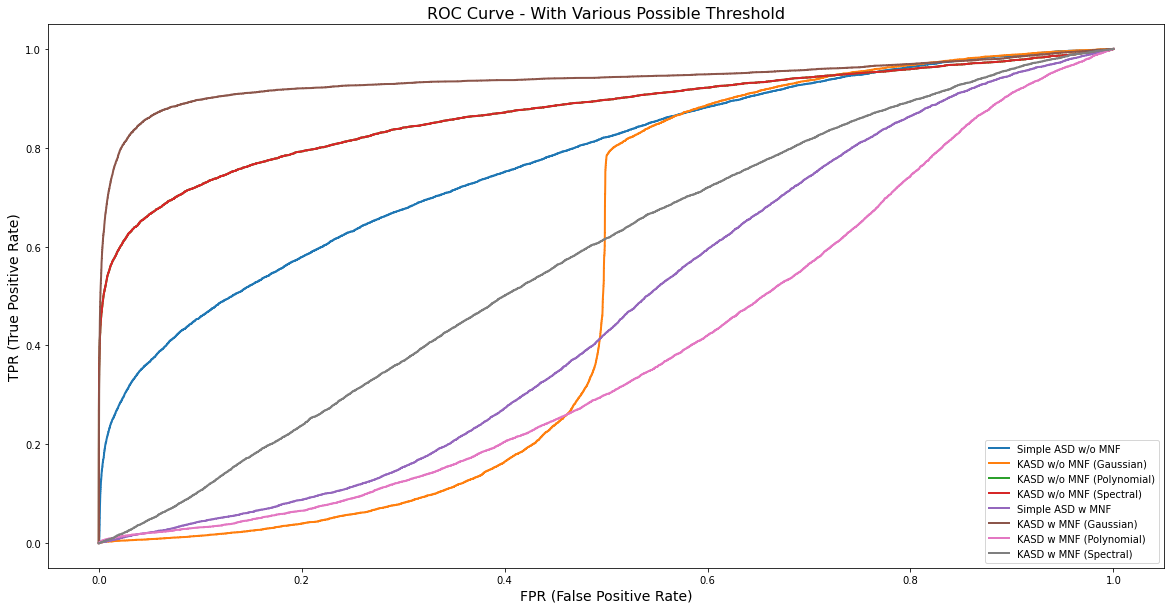

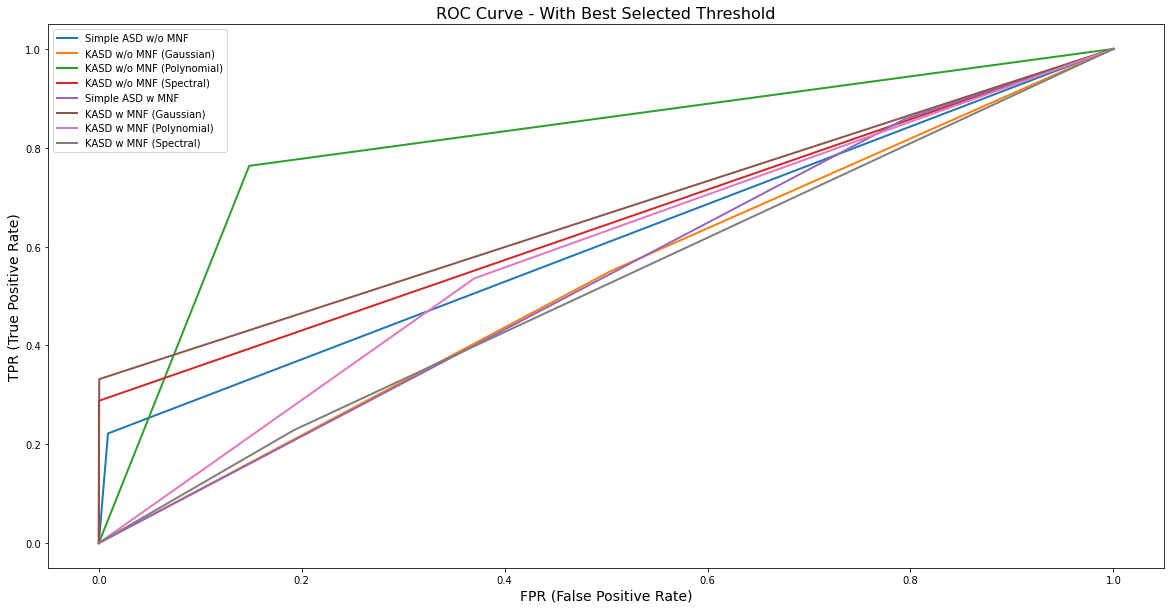

In [3]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)

# reload all pickle files for plotting 

with open("./kernel_data/y_ASD.pkl","rb") as f:
    y_ASD = pkl.load(f)
with open("./kernel_data/PREDS_ASD.pkl","rb") as f:
    PREDS_ASD = pkl.load(f)
with open("./kernel_data/GT_LABELS_ASD.pkl","rb") as f:
    GT_LABELS_ASD = pkl.load(f)
    
    
with open("./kernel_data/y_KASD_Gaussian.pkl","rb") as f:
    y_KASD_Gaussian = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Gaussian.pkl","rb") as f:
    PREDS_KASD_Gaussian = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Gaussian.pkl","rb") as f:
    GT_LABELS_KASD_Gaussian = pkl.load(f)
    

with open("./kernel_data/y_KASD_Polynomial.pkl","rb") as f:
    y_KASD_Polynomial = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Polynomial.pkl","rb") as f:
    PREDS_KASD_Polynomial = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Polynomial.pkl","rb") as f:
    GT_LABELS_KASD_Polynomial = pkl.load(f)
    
    
with open("./kernel_data/y_KASD_Spectral.pkl","rb") as f:
    y_KASD_Spectral = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Spectral.pkl","rb") as f:
    PREDS_KASD_Spectral = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Spectral.pkl","rb") as f:
    GT_LABELS_KASD_Spectral = pkl.load(f)
    

    
with open("./kernel_data/y_ASD_MNF.pkl","rb") as f:
    y_ASD_MNF = pkl.load(f)
with open("./kernel_data/PREDS_ASD_MNF.pkl","rb") as f:
    PREDS_ASD_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_ASD_MNF.pkl","rb") as f:
    GT_LABELS_ASD_MNF = pkl.load(f)
    
    
with open("./kernel_data/y_KASD_Gaussian_MNF.pkl","rb") as f:
    y_KASD_Gaussian_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Gaussian_MNF.pkl","rb") as f:
    PREDS_KASD_Gaussian_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Gaussian_MNF.pkl","rb") as f:
    GT_LABELS_KASD_Gaussian_MNF = pkl.load(f)
    

with open("./kernel_data/y_KASD_Polynomial_MNF.pkl","rb") as f:
    y_KASD_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Polynomial_MNF.pkl","rb") as f:
    PREDS_KASD_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Polynomial_MNF.pkl","rb") as f:
    GT_LABELS_KASD_Polynomial_MNF = pkl.load(f)
    
    
with open("./kernel_data/y_KASD_Spectral_MNF.pkl","rb") as f:
    y_KASD_Spectral_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KASD_Spectral_MNF.pkl","rb") as f:
    PREDS_KASD_Spectral_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KASD_Spectral_MNF.pkl","rb") as f:
    GT_LABELS_KASD_Spectral_MNF = pkl.load(f)

############################ Plot 1 - ROC Curve with Various Possible Thresholds #################################    
plt.figure(figsize=(20,10))

# using sklearn's roc_curve method to get FPR, TPR & Thresholds for each

# just a minot hack for y_ASD_MNF here as it was throwing some weird error with list type
GT_LABELS_ASD, y_ASD = np.array(GT_LABELS_ASD).reshape(-1,1), np.array(y_ASD).reshape(-1,1)
GT_LABELS_ASD_MNF, y_ASD_MNF = np.array(GT_LABELS_ASD_MNF).reshape(-1,1), np.array(y_ASD_MNF).reshape(-1,1)

fpr_ASD, tpr_ASD, _                              = roc_curve(GT_LABELS_ASD, y_ASD)
fpr_KASD_Gaussian, tpr_KASD_Gaussian, _                  = roc_curve(GT_LABELS_KASD_Gaussian, y_KASD_Gaussian)
fpr_KASD_Polynomial, tpr_KASD_Polynomial, _      = roc_curve(GT_LABELS_KASD_Polynomial, y_KASD_Polynomial)
fpr_KASD_Spectral, tpr_KASD_Spectral,_ = roc_curve(GT_LABELS_KASD_Spectral, y_KASD_Spectral)

fpr_ASD_MNF, tpr_ASD_MNF, _                              = roc_curve(GT_LABELS_ASD_MNF, y_ASD_MNF)
fpr_KASD_Gaussian_MNF, tpr_KASD_Gaussian_MNF, _                  = roc_curve(GT_LABELS_KASD_Gaussian_MNF, y_KASD_Gaussian_MNF)
fpr_KASD_Polynomial_MNF, tpr_KASD_Polynomial_MNF, _      = roc_curve(GT_LABELS_KASD_Polynomial_MNF, y_KASD_Polynomial_MNF)
fpr_KASD_Spectral_MNF, tpr_KASD_Spectral_MNF,_ = roc_curve(GT_LABELS_KASD_Spectral_MNF, y_KASD_Spectral_MNF)

plot_roc_curve(fpr_ASD, tpr_ASD, label="Simple ASD w/o MNF ")
plot_roc_curve(fpr_KASD_Gaussian, tpr_KASD_Gaussian, label="KASD w/o MNF (Gaussian)")
plot_roc_curve(fpr_KASD_Polynomial, tpr_KASD_Polynomial, label="KASD w/o MNF (Polynomial)")
plot_roc_curve(fpr_KASD_Spectral, tpr_KASD_Spectral, label="KASD w/o MNF (Spectral)")

plot_roc_curve(fpr_ASD_MNF, tpr_ASD_MNF, label="Simple ASD w MNF ")
plot_roc_curve(fpr_KASD_Gaussian_MNF, tpr_KASD_Gaussian_MNF, label="KASD w MNF (Gaussian)")
plot_roc_curve(fpr_KASD_Polynomial_MNF, tpr_KASD_Polynomial_MNF, label="KASD w MNF (Polynomial)")
plot_roc_curve(fpr_KASD_Spectral_MNF, tpr_KASD_Spectral_MNF, label="KASD w MNF (Spectral)")

plt.xlabel("FPR (False Positive Rate)", size=14)
plt.ylabel("TPR (True Positive Rate)", size=14)
plt.legend()
plt.title("ROC Curve - With Various Possible Threshold", size=16)
plt.savefig("./pics/ROC_PossibleThresholds.png")
#############################################################################################################


# ############################ Plot 2 - ROC Curve with Best Selected Threshold During Testing Above #################################    
plt.figure(figsize=(20,10))
# using sklearn's roc_curve method to get FPR, TPR & Thresholds for each
fpr_ASD, tpr_ASD, _                              = roc_curve(GT_LABELS_ASD, PREDS_ASD)
fpr_KASD_Gaussian, tpr_KASD_Gaussian, _                  = roc_curve(GT_LABELS_KASD_Gaussian, PREDS_KASD_Gaussian)
fpr_KASD_Polynomial, tpr_KASD_Polynomial, _      = roc_curve(GT_LABELS_KASD_Polynomial, PREDS_KASD_Polynomial)
fpr_KASD_Spectral, tpr_KASD_Spectral,_ = roc_curve(GT_LABELS_KASD_Spectral, PREDS_KASD_Spectral)

fpr_ASD_MNF, tpr_ASD_MNF, _                              = roc_curve(GT_LABELS_ASD_MNF, PREDS_ASD_MNF)
fpr_KASD_Gaussian_MNF, tpr_KASD_Gaussian_MNF, _                  = roc_curve(GT_LABELS_KASD_Gaussian_MNF, PREDS_KASD_Gaussian_MNF)
fpr_KASD_Polynomial_MNF, tpr_KASD_Polynomial_MNF, _      = roc_curve(GT_LABELS_KASD_Polynomial_MNF, PREDS_KASD_Polynomial_MNF)
fpr_KASD_Spectral_MNF, tpr_KASD_Spectral_MNF,_ = roc_curve(GT_LABELS_KASD_Spectral_MNF, PREDS_KASD_Spectral_MNF)



plot_roc_curve(fpr_ASD, tpr_ASD, label="Simple ASD w/o MNF ")
plot_roc_curve(fpr_KASD_Gaussian, tpr_KASD_Gaussian, label="KASD w/o MNF (Gaussian)")
plot_roc_curve(fpr_KASD_Polynomial, tpr_KASD_Polynomial, label="KASD w/o MNF (Polynomial)")
plot_roc_curve(fpr_KASD_Spectral, tpr_KASD_Spectral, label="KASD w/o MNF (Spectral)")

plot_roc_curve(fpr_ASD_MNF, tpr_ASD_MNF, label="Simple ASD w MNF ")
plot_roc_curve(fpr_KASD_Gaussian_MNF, tpr_KASD_Gaussian_MNF, label="KASD w MNF (Gaussian)")
plot_roc_curve(fpr_KASD_Polynomial_MNF, tpr_KASD_Polynomial_MNF, label="KASD w MNF (Polynomial)")
plot_roc_curve(fpr_KASD_Spectral_MNF, tpr_KASD_Spectral_MNF, label="KASD w MNF (Spectral)")

plt.xlabel("FPR (False Positive Rate)", size=14)
plt.ylabel("TPR (True Positive Rate)", size=14)
plt.legend()
plt.title("ROC Curve - With Best Selected Threshold", size=16)

plt.savefig("./pics/ROC_SelectedThreshold.png")
# #############################################################################################################